# Metrics of Fine tuning Mini-Replica with augmented images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

import sys
sys.path.insert(0, "./../../../src/utils/")
from utils import winapi_path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_dir = "./../../../data/model_learning/"
scores_dir = data_dir + "scores/"
losses_dir = data_dir + "losses/"
lr_dir = data_dir + "learning_rates/"

scores_folder = "scores_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
losses_folder = "losses_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
lr_folder = "lr_lft-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_with-aug-images_noaugintest"
train_param = "Mini-Replica Resnext-101, 280 res, Batch 4, adam_e-6, steplr_10-0.1, Loss Marg-0.7, 10 triplets, with aug images"

In [2]:
def read_losses_scores_lr(curr_losses_folder, curr_scores_folder, curr_lr_folder, split_id):
    
    if split_id:
        curr_scores_folder = curr_scores_folder + "_v" + str(split_id) + "/"
        curr_losses_folder = curr_losses_folder + "_v" + str(split_id) + "/"
        curr_lr_folder = curr_lr_folder + "_v" + str(split_id) + "/"
    else:    
        curr_scores_folder = curr_scores_folder + "/"
        curr_losses_folder = curr_losses_folder + "/"
        curr_lr_folder = curr_lr_folder + "/"
        
    
    train_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "train_loss.csv"))
    val_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "validation_loss.csv"))


    train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "train_scores.csv"))
    val_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "validation_scores.csv"))
    test_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test_scores.csv"))
    non_train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test-and-val_scores.csv"))
    
    learning_rates = pd.read_csv(winapi_path(lr_dir + curr_lr_folder + "learning_rate.csv"))
    
    return train_loss, val_loss, train_scores, val_scores, test_scores, non_train_scores, learning_rates


def highlight_df_scores(score_df):
    return (score_df.style.highlight_min(color = 'lightgreen', axis = 0, subset=['mean_position','mean_min_position', 'mean_median_position'])
 .highlight_max(color = 'lightblue', axis = 0, subset=['map','recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']))


def plot_mean_position(train_df, val_df, test_df, test_val_df, train_param):
    plts = plt.figure(figsize=(9, 6))
    plt.plot(train_df['mean_position'], label="train")
    if val_df is not None:
        plt.plot(val_df['mean_position'], label="validation")
    if test_df is not None:
        plt.plot(test_df['mean_position'], label="test")
    if test_val_df is not None:
        plt.plot(test_val_df['mean_position'], label="Non-Train")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Position of retrived artwork")
    plt.legend()
    plt.title("Average position of the expected artwork in the list of retrived artworks")
    plt.suptitle(train_param)
    plt.grid()
    plts.tight_layout()
    
    
def plot_recall_at_k(train_df, val_df, test_df, test_val_df, train_param, recall_columns = ['recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']):

    plts = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plts)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=plts, sharey=ax1)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=plts, sharey=ax1)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=plts, sharey=ax1)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=plts, sharey=ax1)

    axs = [ax1, ax2, ax3, ax4, ax5]

    for num, name in enumerate(recall_columns):

        axs[num].plot(train_df[name], label="train")
        axs[num].plot(val_df[name], label="validation")
        axs[num].plot(test_df[name], label="test")
        if test_val_df is not None:
            axs[num].plot(test_val_df[name], label="non-train")
        axs[num].set_xlabel("Epoch")
        axs[num].set_ylabel(name)
        axs[num].legend()
        axs[num].set_title(name.replace("_", "@").replace("recall", "Recall"))
        axs[num].grid()
        axs[num].xaxis.set_major_locator(MaxNLocator(integer=True))


    plts.suptitle("{}\nRecall@k".format(train_param))
    plt.yticks(np.linspace(0, 1, 11))
    plt.margins(x=0.02)
    plts.tight_layout()
    
    
def get_averaged_df(score_dataframe):
    a = score_dataframe.groupby("model").agg(['mean', 'std'])
    a.columns = list(map('_'.join, a.columns.values))
    a["MP"] = round(a["MP_mean"], 2).astype(str) + " ± " + round(a["MP_std"], 2).astype(str)
    a["MMP"] = round(a["MMP_mean"], 2).astype(str) + " ± " + round(a["MMP_std"], 2).astype(str)
    a["mean_median_position"] = round(a["mean_median_position_mean"], 2).astype(str) + " ± " + round(a["mean_median_position_std"], 2).astype(str)
    a["MAP"] = round(a["MAP_mean"], 2).astype(str) + " ± " + round(a["MAP_std"], 2).astype(str)
    a["R@400"] = round(a["R@400_mean"], 2).astype(str) + " ± " + round(a["R@400_std"], 2).astype(str)
    a["R@200"] = round(a["R@200_mean"], 2).astype(str) + " ± " + round(a["R@200_std"], 2).astype(str)
    a["R@100"] = round(a["R@100_mean"], 2).astype(str) + " ± " + round(a["R@100_std"], 2).astype(str)
    a["R@50"] = round(a["R@50_mean"], 2).astype(str) + " ± " + round(a["R@50_std"], 2).astype(str)
    a["R@20"] = round(a["R@20_mean"], 2).astype(str) + " ± " + round(a["R@20_std"], 2).astype(str)

    b = a[["MP", "MMP", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20']].reset_index()
    score_dataframe_avg_df = b.replace({"resnet": "ResNet-101", "resnext": "ResNeXT-101"})
    
    return score_dataframe_avg_df

In [4]:
train_metrics, val_metrics, test_metrics, non_train_metrics = [], [], [], []

## Data Split - v0

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,614.098246,736.387097,590.111111,0.201103,0.672043,0.593190,0.505376,0.444444,0.353047
1,240.332456,55.507168,230.359319,0.549689,0.955197,0.921147,0.888889,0.822581,0.750896
2,205.578947,14.164875,203.754480,0.738437,0.991039,0.980287,0.971326,0.940860,0.903226
3,201.869298,5.937276,199.461470,0.860033,0.994624,0.991039,0.983871,0.976703,0.964158
4,276.577193,143.175627,270.489247,0.717332,0.924731,0.912186,0.888889,0.867384,0.844086


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,782.625000,1247.526316,802.815789,0.427962,0.631579,0.631579,0.578947,0.526316,0.473684
1,314.450000,261.894737,310.000000,0.485289,0.842105,0.789474,0.684211,0.684211,0.631579
2,352.325000,341.631579,349.868421,0.530385,0.842105,0.842105,0.736842,0.736842,0.684211
3,377.225000,394.052632,376.078947,0.485841,0.789474,0.789474,0.789474,0.631579,0.631579
4,584.200000,825.894737,595.894737,0.336604,0.789474,0.684211,0.631579,0.526316,0.421053


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,267.150000,118.736842,275.000000,0.444401,0.789474,0.789474,0.631579,0.631579,0.631579
1,408.400000,454.947368,410.894737,0.450167,0.894737,0.894737,0.894737,0.736842,0.631579
2,377.400000,393.894737,376.526316,0.509974,0.894737,0.894737,0.894737,0.842105,0.684211
3,315.700000,257.263158,314.631579,0.496561,0.947368,0.842105,0.842105,0.736842,0.684211
4,297.625000,220.052632,295.447368,0.331103,0.894737,0.789474,0.684211,0.578947,0.578947


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,524.887500,683.131579,538.907895,0.436181,0.710526,0.710526,0.605263,0.578947,0.552632
1,361.425000,358.421053,360.447368,0.467728,0.868421,0.842105,0.789474,0.710526,0.631579
2,364.862500,367.763158,363.197368,0.520180,0.868421,0.868421,0.815789,0.789474,0.684211
3,346.462500,325.657895,345.355263,0.491201,0.868421,0.815789,0.815789,0.684211,0.657895
4,440.912500,522.973684,445.671053,0.333853,0.842105,0.736842,0.657895,0.552632,0.500000


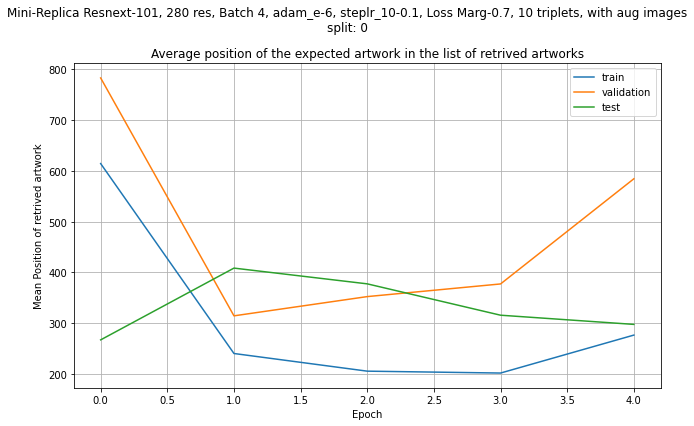

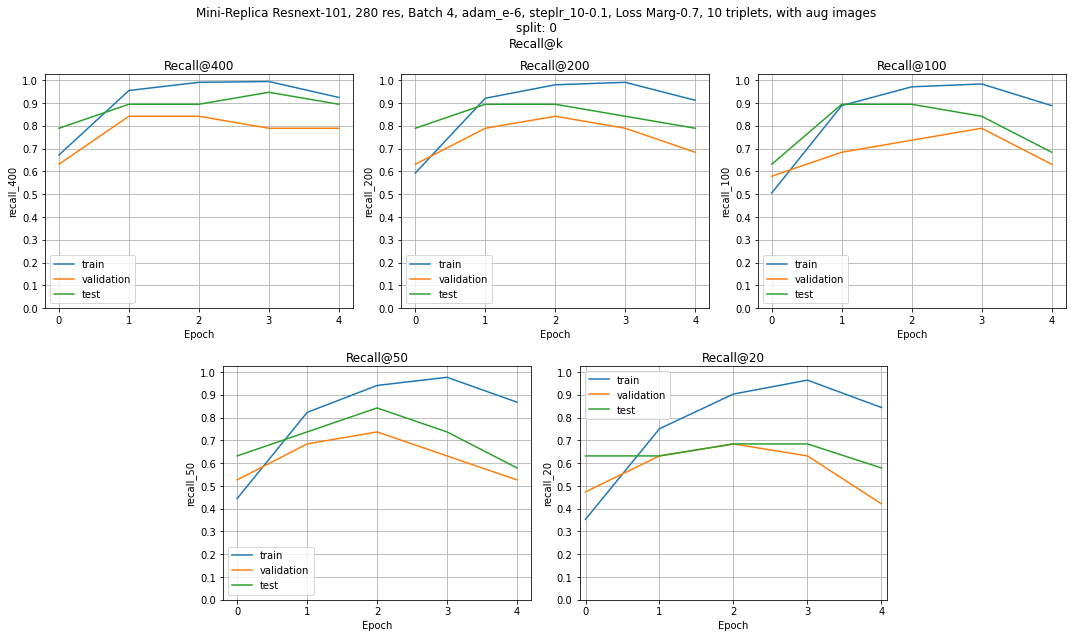

In [5]:
split_id = 0

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [6]:
best_epoch = 2

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v1

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,579.851190,660.637500,552.120833,0.241606,0.693750,0.622917,0.543750,0.483333,0.395833
1,273.321429,117.170833,254.454167,0.487862,0.941667,0.904167,0.833333,0.781250,0.693750
2,218.773810,42.933333,210.812500,0.686240,0.979167,0.968750,0.954167,0.927083,0.862500
3,196.375000,5.483333,187.583333,0.801260,0.995833,0.993750,0.983333,0.964583,0.931250
4,192.182540,2.137500,182.412500,0.888312,1.000000,1.000000,0.993750,0.979167,0.968750


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,566.000000,732.000000,566.000000,0.245349,0.766667,0.566667,0.466667,0.333333,0.266667
1,374.133333,348.266667,374.133333,0.300024,0.900000,0.833333,0.700000,0.633333,0.500000
2,362.433333,324.866667,362.433333,0.312868,0.833333,0.800000,0.733333,0.633333,0.466667
3,317.233333,234.466667,317.233333,0.293522,0.833333,0.800000,0.733333,0.533333,0.433333
4,354.000000,308.000000,354.000000,0.246638,0.766667,0.700000,0.533333,0.500000,0.433333


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,419.071429,438.142857,419.071429,0.300380,0.809524,0.809524,0.761905,0.761905,0.666667
1,373.619048,347.238095,373.619048,0.403412,0.857143,0.761905,0.714286,0.619048,0.523810
2,392.166667,384.333333,392.166667,0.383588,0.857143,0.761905,0.761905,0.619048,0.571429
3,374.380952,348.761905,374.380952,0.318333,0.857143,0.857143,0.666667,0.619048,0.571429
4,407.928571,415.857143,407.928571,0.367580,0.809524,0.761905,0.666667,0.571429,0.523810


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,505.500000,611.000000,505.500000,0.268009,0.784314,0.666667,0.588235,0.509804,0.431373
1,373.921569,347.843137,373.921569,0.342595,0.882353,0.803922,0.705882,0.627451,0.509804
2,374.676471,349.352941,374.676471,0.341988,0.843137,0.784314,0.745098,0.627451,0.509804
3,340.764706,281.529412,340.764706,0.303738,0.843137,0.823529,0.705882,0.568627,0.490196
4,376.205882,352.411765,376.205882,0.296438,0.784314,0.725490,0.588235,0.529412,0.470588


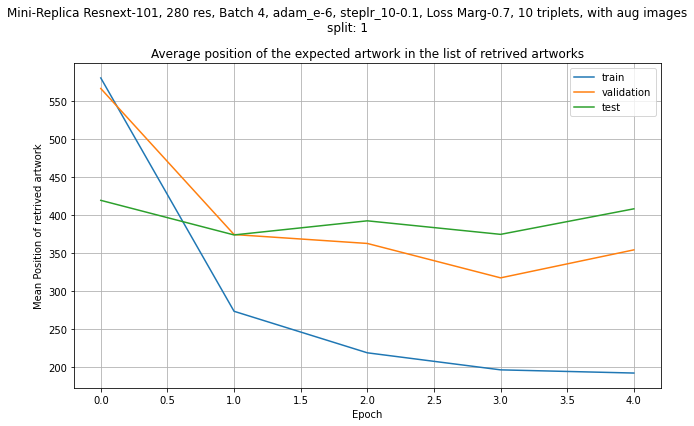

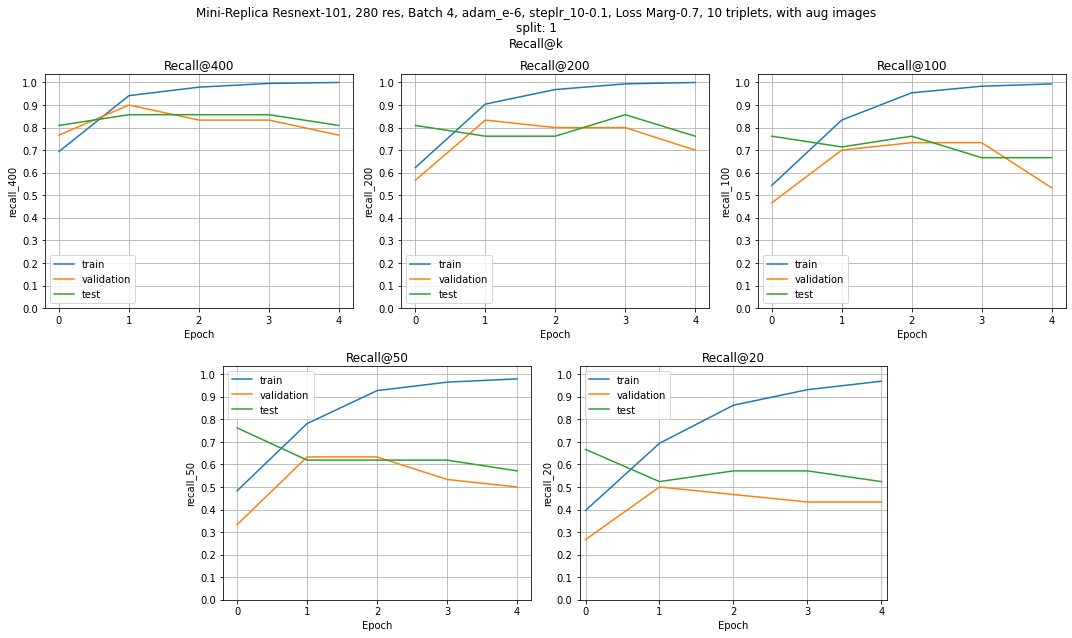

In [7]:
split_id = 1

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [8]:
best_epoch = 1

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v2

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,568.450000,641.810976,543.108740,0.268366,0.717480,0.656504,0.591463,0.528455,0.430894
1,250.610784,73.888211,232.940041,0.528416,0.953252,0.916667,0.855691,0.796748,0.737805
2,202.626471,12.567073,197.848577,0.775208,0.987805,0.983740,0.975610,0.953252,0.930894
3,197.823529,5.520325,192.670732,0.868577,0.995935,0.989837,0.985772,0.979675,0.965447
4,195.435294,3.426829,188.815041,0.899778,0.997967,0.997967,0.991870,0.983740,0.975610


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,564.954545,729.909091,564.954545,0.283134,0.636364,0.590909,0.500000,0.500000,0.500000
1,421.272727,442.545455,421.272727,0.329385,0.772727,0.727273,0.590909,0.590909,0.409091
2,381.568182,363.136364,381.568182,0.416946,0.818182,0.681818,0.636364,0.590909,0.500000
3,383.568182,367.136364,383.568182,0.373011,0.772727,0.727273,0.681818,0.545455,0.454545
4,375.454545,350.909091,375.454545,0.306349,0.772727,0.772727,0.681818,0.545455,0.454545


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,473.553571,551.444444,486.722222,0.120852,0.740741,0.518519,0.407407,0.259259,0.185185
1,349.767857,323.444444,348.722222,0.179387,0.888889,0.740741,0.629630,0.518519,0.370370
2,344.357143,313.259259,342.777778,0.248937,0.925926,0.777778,0.703704,0.592593,0.518519
3,358.482143,342.629630,357.388889,0.200955,0.888889,0.740741,0.666667,0.592593,0.518519
4,303.714286,229.481481,300.296296,0.224251,0.814815,0.740741,0.703704,0.629630,0.444444


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,513.770000,631.571429,521.846939,0.193713,0.693878,0.551020,0.448980,0.367347,0.326531
1,381.230000,376.918367,381.295918,0.246733,0.836735,0.734694,0.612245,0.551020,0.387755
2,360.730000,335.653061,360.193878,0.324370,0.877551,0.734694,0.673469,0.591837,0.510204
3,369.520000,353.632653,369.142857,0.278205,0.836735,0.734694,0.673469,0.571429,0.489796
4,335.280000,284.000000,334.040816,0.261111,0.795918,0.755102,0.693878,0.591837,0.448980


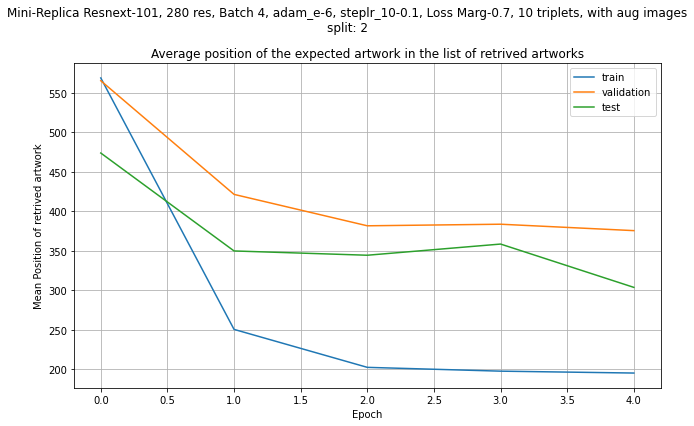

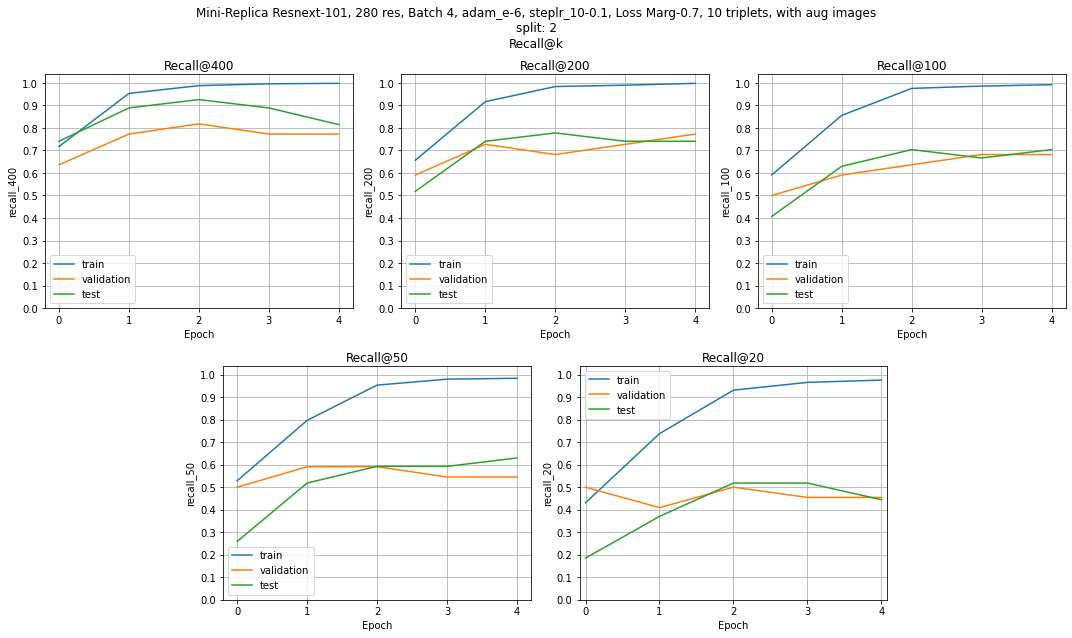

In [9]:
split_id = 2

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [10]:
best_epoch = 2

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v3

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,504.789530,619.919913,507.133117,0.273567,0.742424,0.675325,0.616883,0.541126,0.463203
1,221.462607,48.547619,219.174242,0.567579,0.971861,0.948052,0.904762,0.850649,0.787879
2,203.946581,12.948052,201.502165,0.762083,0.989177,0.987013,0.974026,0.958874,0.919913
3,198.496795,1.997835,195.905844,0.879337,1.000000,1.000000,0.995671,0.991342,0.971861
4,205.122863,15.448052,202.604978,0.895198,0.991342,0.984848,0.980519,0.976190,0.956710


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,445.050000,425.689655,421.741379,0.139114,0.724138,0.517241,0.413793,0.310345,0.241379
1,295.483333,203.827586,295.258621,0.195247,0.827586,0.758621,0.586207,0.448276,0.275862
2,241.250000,91.068966,239.706897,0.216705,0.931034,0.862069,0.827586,0.689655,0.482759
3,237.683333,90.931034,232.396552,0.258849,0.931034,0.896552,0.827586,0.620690,0.482759
4,253.816667,122.379310,249.672414,0.209684,0.862069,0.827586,0.793103,0.689655,0.551724


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,579.222222,665.120000,587.080000,0.235329,0.600000,0.560000,0.440000,0.440000,0.360000
1,630.703704,388.640000,394.880000,0.282324,0.800000,0.800000,0.800000,0.680000,0.560000
2,715.666667,532.240000,466.160000,0.310955,0.800000,0.800000,0.800000,0.760000,0.680000
3,663.777778,412.160000,410.520000,0.315028,0.800000,0.800000,0.760000,0.640000,0.520000
4,663.870370,441.800000,413.820000,0.275294,0.800000,0.760000,0.640000,0.600000,0.520000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,508.605263,536.537037,498.287037,0.183658,0.666667,0.537037,0.425926,0.370370,0.296296
1,454.271930,289.388889,341.379630,0.235560,0.814815,0.777778,0.685185,0.555556,0.407407
2,465.973684,295.314815,344.546296,0.260339,0.870370,0.833333,0.814815,0.722222,0.574074
3,439.517544,239.648148,314.861111,0.284858,0.870370,0.851852,0.796296,0.629630,0.500000
4,448.052632,270.259259,325.666667,0.240059,0.833333,0.796296,0.722222,0.648148,0.537037


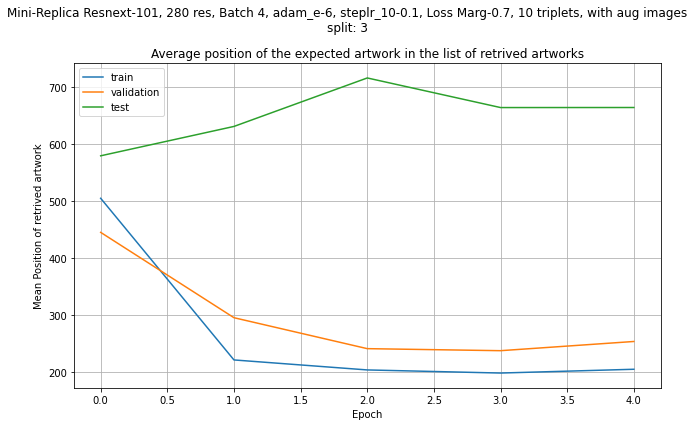

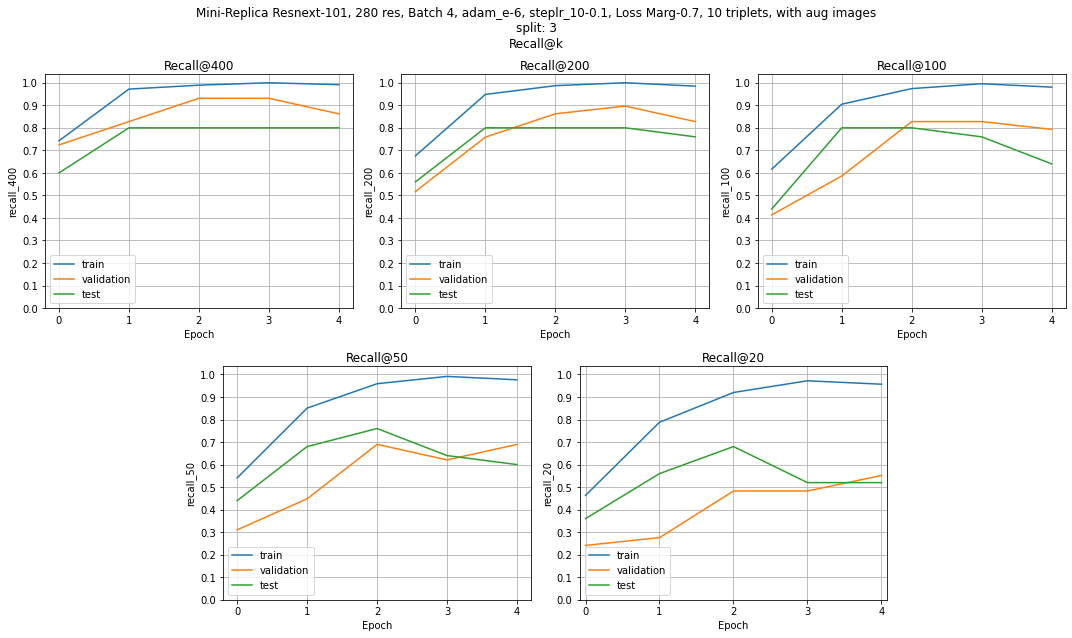

In [11]:
split_id = 3

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [12]:
best_epoch = 3

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v4

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,531.323293,598.349794,519.090535,0.262678,0.732510,0.662551,0.586420,0.522634,0.440329
1,271.564257,79.370370,239.358025,0.549112,0.944444,0.903292,0.870370,0.818930,0.759259
2,229.140562,27.534979,213.115226,0.730648,0.977366,0.969136,0.954733,0.932099,0.888889
3,203.871486,3.148148,199.469136,0.852856,0.991770,0.985597,0.979424,0.973251,0.965021
4,203.332329,13.446502,200.007202,0.878371,0.995885,0.991770,0.987654,0.975309,0.954733


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,533.145161,674.166667,546.983333,0.100609,0.700000,0.500000,0.366667,0.266667,0.200000
1,312.161290,244.400000,309.266667,0.198436,0.900000,0.866667,0.766667,0.633333,0.366667
2,311.661290,243.766667,308.783333,0.210749,0.900000,0.833333,0.633333,0.533333,0.400000
3,285.709677,189.733333,282.233333,0.245222,0.900000,0.866667,0.766667,0.700000,0.500000
4,323.209677,267.500000,320.716667,0.243342,0.900000,0.833333,0.766667,0.666667,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,459.261905,426.550000,426.175000,0.363515,0.650000,0.650000,0.550000,0.550000,0.400000
1,487.214286,565.850000,498.775000,0.358412,0.800000,0.700000,0.650000,0.450000,0.450000
2,469.476190,520.200000,478.900000,0.319597,0.750000,0.750000,0.600000,0.550000,0.500000
3,339.666667,308.300000,337.100000,0.342379,0.850000,0.750000,0.700000,0.600000,0.500000
4,313.500000,243.250000,315.875000,0.352530,0.750000,0.700000,0.600000,0.550000,0.550000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,503.307692,575.120000,498.660000,0.205772,0.680000,0.560000,0.440000,0.380000,0.280000
1,382.855769,372.980000,385.070000,0.262427,0.860000,0.800000,0.720000,0.560000,0.400000
2,375.394231,354.340000,376.830000,0.254288,0.840000,0.800000,0.620000,0.540000,0.440000
3,307.500000,237.160000,304.180000,0.284085,0.880000,0.820000,0.740000,0.660000,0.500000
4,319.288462,257.800000,318.780000,0.287018,0.840000,0.780000,0.700000,0.620000,0.520000


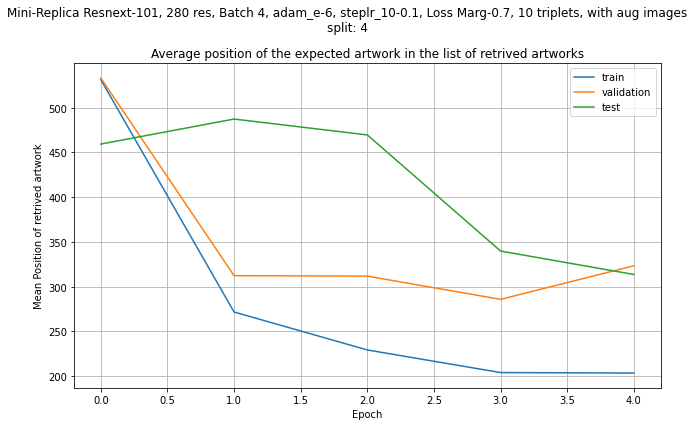

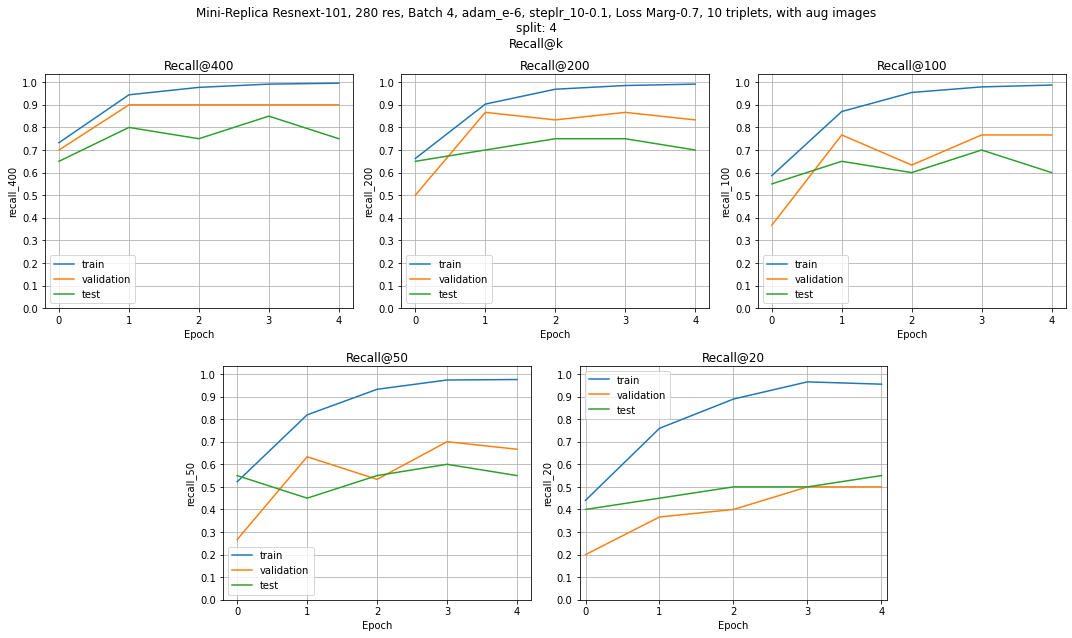

In [13]:
split_id = 4

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [14]:
best_epoch = 3

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v5

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,656.153101,824.702811,634.287149,0.227230,0.654618,0.578313,0.495984,0.431727,0.359438
1,286.894380,122.945783,258.488956,0.486722,0.937751,0.899598,0.837349,0.773092,0.690763
2,220.939922,34.514056,211.333333,0.713194,0.981928,0.969880,0.957831,0.935743,0.893574
3,197.950581,4.769076,192.756024,0.866891,0.995984,0.985944,0.981928,0.973896,0.961847
4,194.193798,1.650602,187.128514,0.924531,1.000000,0.997992,0.993976,0.987952,0.983936


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,343.431034,286.862069,343.431034,0.318627,0.793103,0.586207,0.517241,0.413793,0.379310
1,257.827586,115.655172,257.827586,0.283196,0.965517,0.896552,0.793103,0.655172,0.482759
2,241.551724,83.103448,241.551724,0.311937,0.965517,0.896552,0.862069,0.724138,0.586207
3,231.620690,63.241379,231.620690,0.420067,0.965517,0.931034,0.862069,0.793103,0.551724
4,240.120690,80.241379,240.120690,0.377076,0.931034,0.896552,0.862069,0.827586,0.586207


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,269.925000,124.578947,277.921053,0.237595,0.842105,0.842105,0.736842,0.736842,0.631579
1,218.325000,54.684211,211.184211,0.375796,0.947368,0.894737,0.789474,0.789474,0.631579
2,230.225000,84.473684,221.394737,0.402556,0.947368,0.789474,0.789474,0.736842,0.631579
3,213.950000,49.684211,204.526316,0.491874,0.947368,0.947368,0.842105,0.789474,0.684211
4,216.500000,53.684211,207.736842,0.453673,0.947368,0.894737,0.894737,0.736842,0.578947


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,313.428571,222.625000,317.500000,0.286552,0.812500,0.687500,0.604167,0.541667,0.479167
1,241.704082,91.520833,239.364583,0.319850,0.958333,0.895833,0.791667,0.708333,0.541667
2,236.928571,83.645833,233.572917,0.347807,0.958333,0.854167,0.833333,0.729167,0.604167
3,224.408163,57.875000,220.895833,0.448491,0.958333,0.937500,0.854167,0.791667,0.604167
4,230.479592,69.729167,227.302083,0.407396,0.937500,0.895833,0.875000,0.791667,0.583333


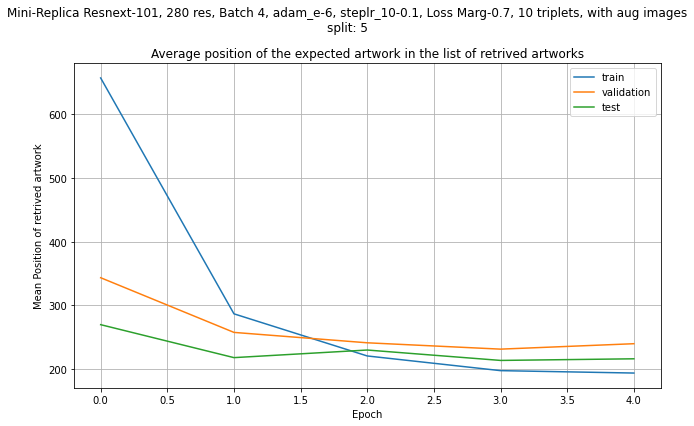

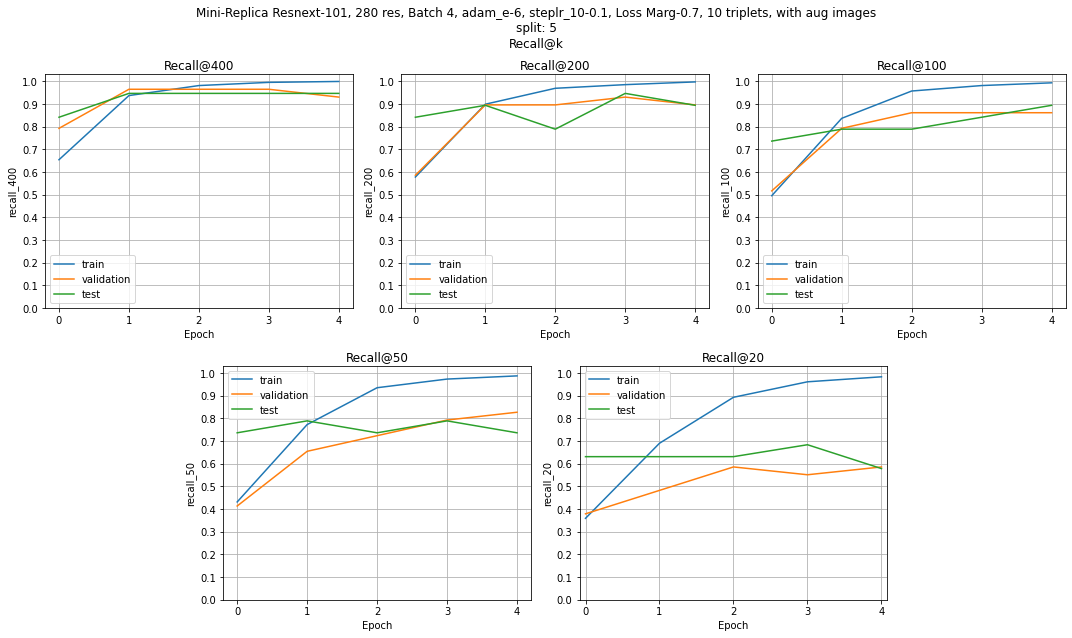

In [15]:
split_id = 5

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [16]:
best_epoch = 3

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v6

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,558.261179,679.052083,541.163542,0.251636,0.702083,0.637500,0.564583,0.508333,0.425000
1,257.870935,121.539583,254.626042,0.549596,0.956250,0.910417,0.881250,0.835417,0.762500
2,226.638211,63.512500,222.535417,0.711643,0.977083,0.968750,0.931250,0.902083,0.860417
3,202.991870,16.062500,198.100000,0.861198,0.993750,0.989583,0.983333,0.975000,0.952083
4,195.553862,0.831250,190.467708,0.926814,1.000000,1.000000,1.000000,1.000000,0.985417


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,459.275000,408.277778,441.250000,0.349464,0.722222,0.722222,0.722222,0.666667,0.500000
1,617.400000,187.000000,291.833333,0.351759,0.777778,0.722222,0.666667,0.666667,0.500000
2,397.825000,151.611111,275.361111,0.295651,0.777778,0.777778,0.722222,0.666667,0.611111
3,522.825000,169.166667,281.527778,0.268056,0.777778,0.777778,0.722222,0.611111,0.500000
4,479.550000,136.666667,265.444444,0.333383,0.777778,0.777778,0.722222,0.611111,0.555556


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,430.727273,461.454545,430.727273,0.275573,0.757576,0.545455,0.484848,0.393939,0.363636
1,380.712121,361.424242,380.712121,0.208277,0.787879,0.666667,0.575758,0.454545,0.393939
2,410.121212,420.242424,410.121212,0.213680,0.757576,0.636364,0.484848,0.454545,0.393939
3,404.333333,408.666667,404.333333,0.191868,0.787879,0.727273,0.545455,0.424242,0.333333
4,386.742424,373.484848,386.742424,0.194541,0.818182,0.727273,0.575758,0.454545,0.424242


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,441.500000,442.686275,434.441176,0.301653,0.745098,0.607843,0.568627,0.490196,0.411765
1,470.028302,299.862745,349.343137,0.258918,0.784314,0.686275,0.607843,0.529412,0.431373
2,405.481132,325.431373,362.558824,0.242611,0.764706,0.686275,0.568627,0.529412,0.470588
3,449.047170,324.137255,360.990196,0.218758,0.784314,0.745098,0.607843,0.490196,0.392157
4,421.764151,289.901961,343.931373,0.243544,0.803922,0.745098,0.627451,0.509804,0.470588


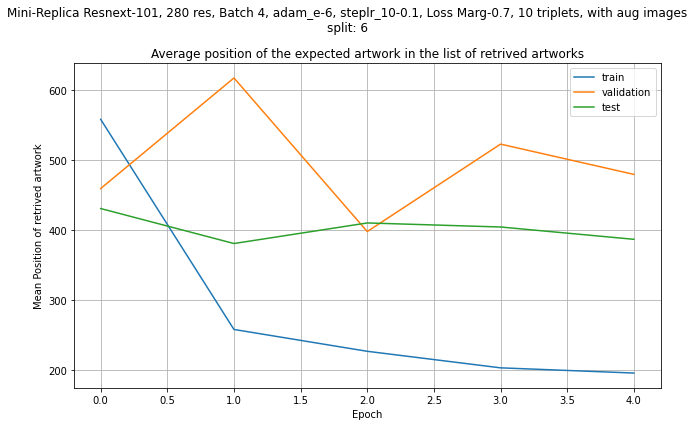

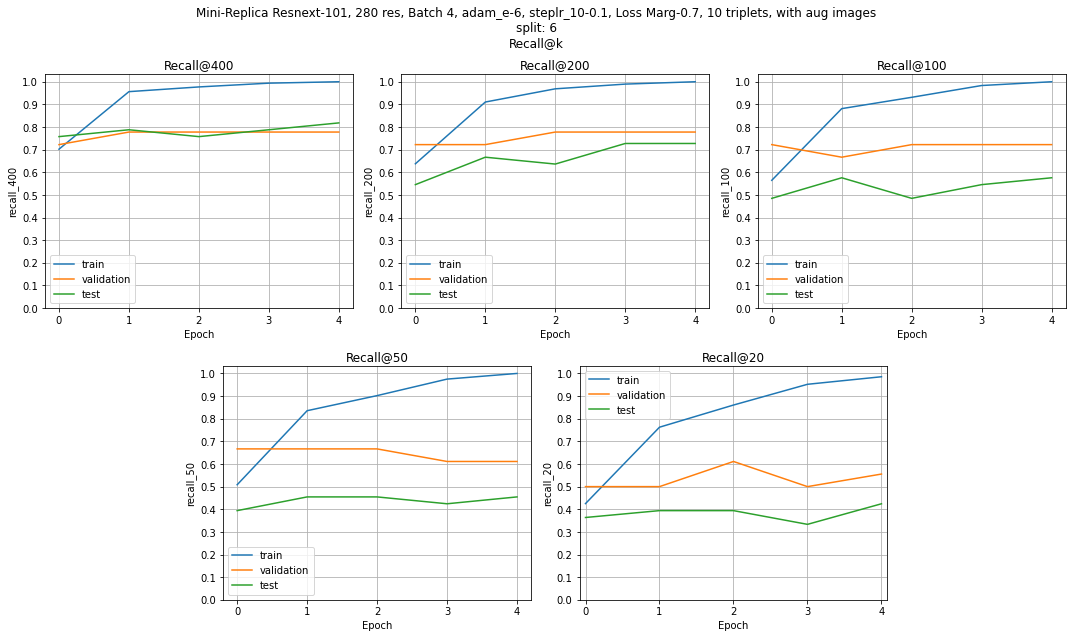

In [17]:
split_id = 6

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [18]:
best_epoch = 2

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v7

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,494.591228,554.211470,478.514337,0.227313,0.713262,0.641577,0.551971,0.487455,0.392473
1,216.792105,38.259857,213.384409,0.625108,0.983871,0.946237,0.901434,0.860215,0.792115
2,202.483333,11.657706,199.122760,0.752461,0.992832,0.983871,0.978495,0.949821,0.906810
3,205.828947,19.822581,201.920251,0.814962,0.991039,0.976703,0.964158,0.949821,0.908602
4,278.127193,160.370968,275.834229,0.682680,0.935484,0.899642,0.874552,0.844086,0.808244


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,835.500000,1271.000000,835.500000,0.280698,0.684211,0.631579,0.526316,0.526316,0.473684
1,542.210526,684.421053,542.210526,0.214821,0.789474,0.684211,0.631579,0.473684,0.473684
2,636.447368,872.894737,636.447368,0.361898,0.578947,0.578947,0.578947,0.473684,0.473684
3,672.973684,945.947368,672.973684,0.261088,0.684211,0.526316,0.526316,0.473684,0.421053
4,1270.578947,2141.157895,1270.578947,0.212012,0.526316,0.526316,0.421053,0.368421,0.368421


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,720.547619,991.631579,730.973684,0.428138,0.631579,0.526316,0.526316,0.526316,0.473684
1,528.142857,96.105263,247.105263,0.425705,0.842105,0.789474,0.684211,0.631579,0.578947
2,435.238095,290.947368,345.473684,0.503754,0.736842,0.684211,0.684211,0.684211,0.578947
3,653.214286,322.473684,361.236842,0.412836,0.736842,0.684211,0.684211,0.684211,0.631579
4,739.809524,523.894737,464.947368,0.316815,0.736842,0.631579,0.578947,0.473684,0.421053


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,775.150000,1131.315789,783.236842,0.354418,0.657895,0.578947,0.526316,0.526316,0.473684
1,534.825000,390.263158,394.657895,0.320263,0.815789,0.736842,0.657895,0.552632,0.526316
2,530.812500,581.921053,490.960526,0.432826,0.657895,0.631579,0.631579,0.578947,0.526316
3,662.600000,634.210526,517.105263,0.336962,0.710526,0.605263,0.605263,0.578947,0.526316
4,991.925000,1332.526316,867.763158,0.264413,0.631579,0.578947,0.500000,0.421053,0.394737


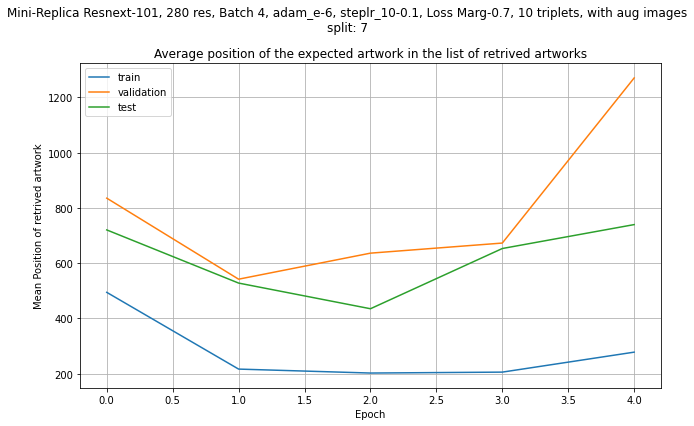

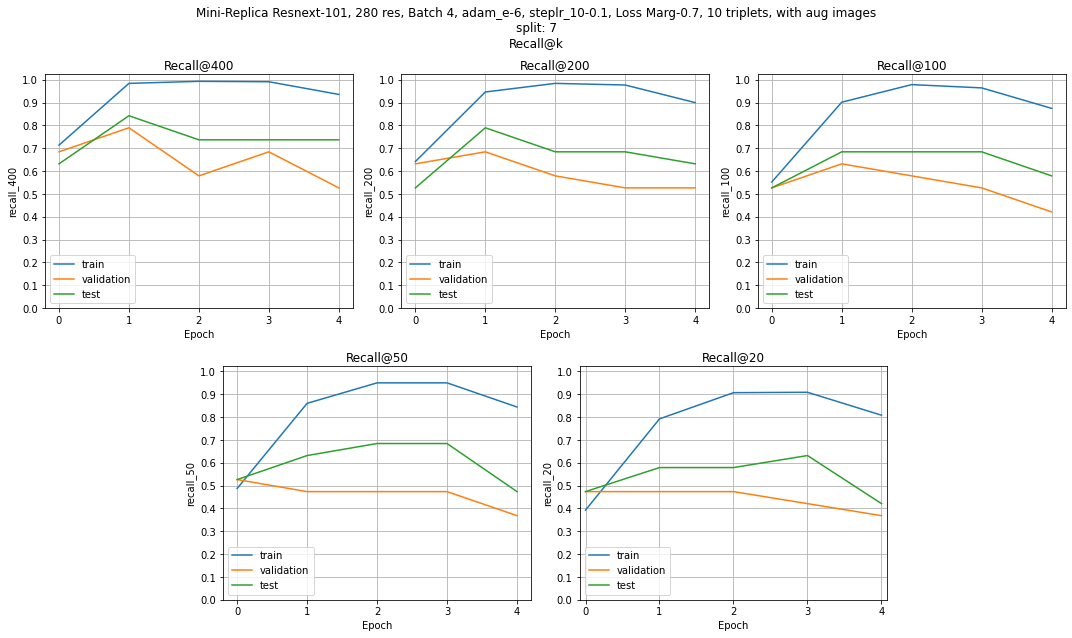

In [19]:
split_id = 7

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [20]:
best_epoch = 1

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v8

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,575.304264,726.606426,562.259036,0.262904,0.696787,0.630522,0.554217,0.495984,0.417671
1,225.156008,60.849398,220.067269,0.540281,0.971888,0.939759,0.889558,0.827309,0.761044
2,199.133721,11.570281,192.375502,0.803534,0.991968,0.987952,0.985944,0.981928,0.957831
3,193.935078,1.785141,186.531124,0.890494,1.000000,1.000000,0.995984,0.987952,0.983936
4,194.821705,3.598394,187.445783,0.884642,1.000000,0.991968,0.991968,0.985944,0.969880


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,538.451613,585.466667,528.266667,0.160621,0.633333,0.433333,0.400000,0.300000,0.266667
1,604.370968,490.100000,457.150000,0.187971,0.800000,0.733333,0.600000,0.466667,0.333333
2,535.016129,314.033333,369.916667,0.221726,0.833333,0.800000,0.766667,0.666667,0.533333
3,566.177419,430.833333,428.383333,0.195905,0.800000,0.766667,0.700000,0.566667,0.466667
4,561.403226,408.033333,417.150000,0.212215,0.766667,0.766667,0.666667,0.600000,0.466667


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,337.555556,275.111111,337.555556,0.359856,0.833333,0.833333,0.777778,0.722222,0.666667
1,312.083333,224.166667,312.083333,0.385843,0.888889,0.888889,0.722222,0.722222,0.555556
2,298.611111,197.222222,298.611111,0.337712,0.944444,0.888889,0.833333,0.666667,0.555556
3,313.888889,227.777778,313.888889,0.247009,0.888889,0.833333,0.777778,0.722222,0.500000
4,473.527778,547.055556,473.527778,0.215625,0.833333,0.777778,0.777778,0.500000,0.333333


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,464.653061,469.083333,456.750000,0.235334,0.708333,0.583333,0.541667,0.458333,0.416667
1,497.000000,390.375000,402.750000,0.262173,0.833333,0.791667,0.645833,0.562500,0.416667
2,448.173469,270.229167,343.177083,0.265221,0.875000,0.833333,0.791667,0.666667,0.541667
3,473.500000,354.687500,385.447917,0.215069,0.833333,0.791667,0.729167,0.625000,0.479167
4,529.122449,460.166667,438.291667,0.213493,0.791667,0.770833,0.708333,0.562500,0.416667


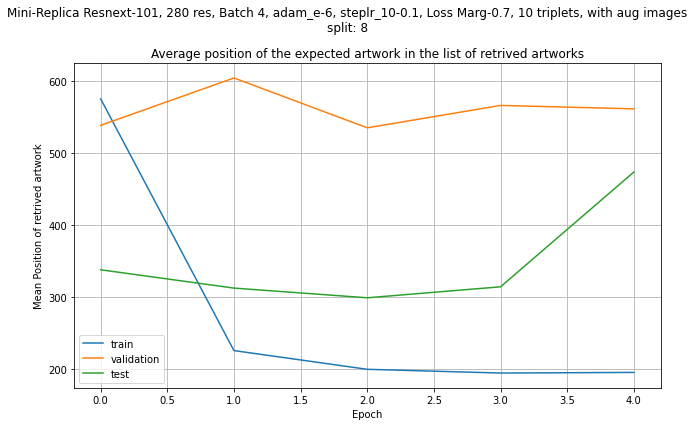

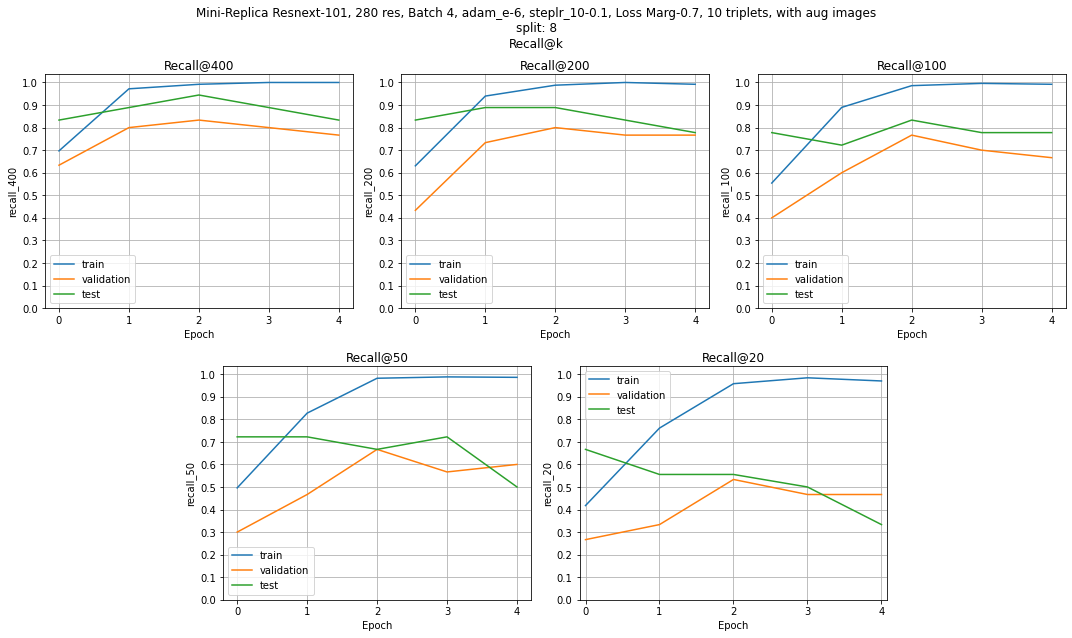

In [21]:
split_id = 8

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [22]:
best_epoch = 2

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v9

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,638.572500,799.484375,617.910590,0.190311,0.656250,0.581597,0.493056,0.425347,0.350694
1,259.185833,96.762153,242.235243,0.533588,0.946181,0.904514,0.859375,0.815972,0.732639
2,209.242500,24.769097,202.815104,0.728860,0.980903,0.967014,0.960069,0.937500,0.904514
3,197.098333,8.083333,189.803819,0.827377,0.993056,0.991319,0.984375,0.965278,0.940972
4,246.545833,89.831597,237.757812,0.703589,0.940972,0.914931,0.895833,0.857639,0.822917


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,433.500000,467.000000,433.500000,0.423316,0.789474,0.736842,0.578947,0.526316,0.526316
1,268.815789,137.631579,268.815789,0.447926,0.947368,0.789474,0.684211,0.631579,0.526316
2,257.763158,115.526316,257.763158,0.452822,0.894737,0.842105,0.789474,0.631579,0.578947
3,263.131579,126.263158,263.131579,0.466657,0.894737,0.736842,0.684211,0.684211,0.631579
4,584.842105,769.684211,584.842105,0.299808,0.631579,0.631579,0.578947,0.578947,0.578947


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,259.656250,119.312500,259.656250,0.492885,0.875000,0.750000,0.750000,0.750000,0.625000
1,231.375000,62.750000,231.375000,0.457282,1.000000,0.875000,0.750000,0.687500,0.687500
2,222.437500,44.875000,222.437500,0.487626,1.000000,0.937500,0.750000,0.750000,0.750000
3,234.281250,68.562500,234.281250,0.494833,1.000000,0.875000,0.750000,0.625000,0.562500
4,310.781250,221.562500,310.781250,0.313053,0.750000,0.687500,0.687500,0.562500,0.562500


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,354.028571,308.057143,354.028571,0.455119,0.828571,0.742857,0.657143,0.628571,0.571429
1,251.700000,103.400000,251.700000,0.452203,0.971429,0.828571,0.714286,0.657143,0.600000
2,241.614286,83.228571,241.614286,0.468732,0.942857,0.885714,0.771429,0.685714,0.657143
3,249.942857,99.885714,249.942857,0.479538,0.942857,0.800000,0.714286,0.657143,0.600000
4,459.557143,519.114286,459.557143,0.305863,0.685714,0.657143,0.628571,0.571429,0.571429


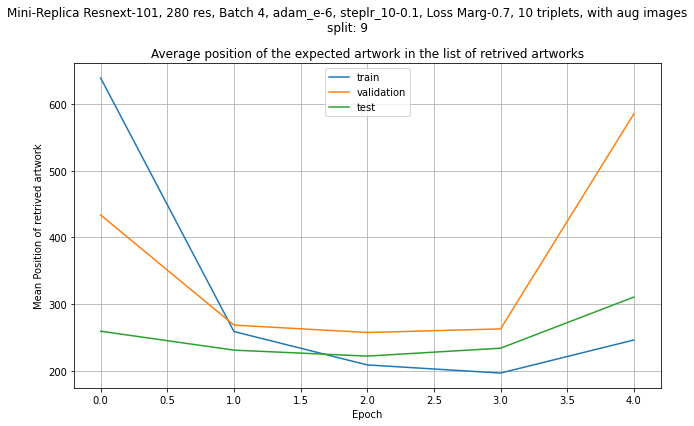

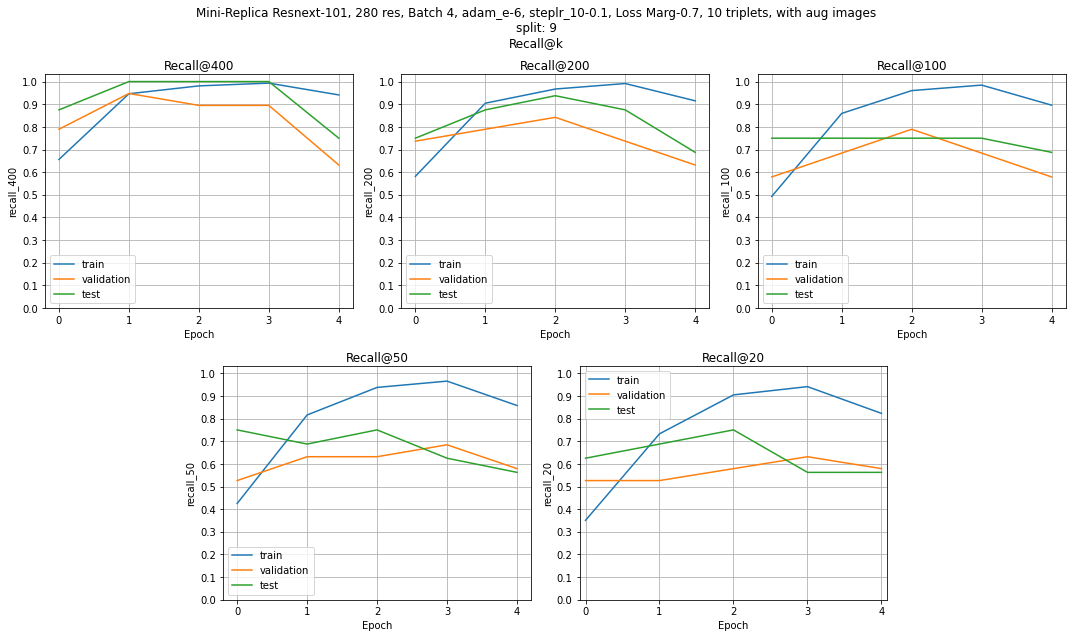

In [23]:
split_id = 9

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [24]:
best_epoch = 3

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v10

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,613.244737,734.643369,589.239247,0.210772,0.670251,0.587814,0.512545,0.448029,0.360215
1,236.825439,42.758065,221.784050,0.596445,0.964158,0.940860,0.908602,0.845878,0.770609
2,213.973684,21.028674,209.037634,0.753065,0.987455,0.973118,0.955197,0.931900,0.910394
3,205.828947,8.338710,201.954301,0.859171,0.991039,0.987455,0.973118,0.960573,0.942652
4,204.435965,12.962366,201.404122,0.850102,0.991039,0.973118,0.958781,0.940860,0.928315


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,558.520833,780.772727,585.795455,0.431117,0.727273,0.727273,0.590909,0.590909,0.500000
1,270.541667,187.545455,260.136364,0.469038,0.863636,0.863636,0.772727,0.727273,0.545455
2,257.958333,153.818182,247.681818,0.508162,0.863636,0.818182,0.818182,0.636364,0.590909
3,335.291667,329.636364,329.909091,0.438543,0.772727,0.727273,0.681818,0.681818,0.500000
4,837.750000,1420.181818,880.272727,0.386547,0.727273,0.681818,0.681818,0.590909,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,406.906250,413.812500,406.906250,0.335062,0.812500,0.812500,0.687500,0.625000,0.500000
1,465.812500,531.625000,465.812500,0.421605,0.875000,0.812500,0.687500,0.687500,0.562500
2,465.343750,530.687500,465.343750,0.332949,0.875000,0.687500,0.687500,0.625000,0.500000
3,591.656250,783.312500,591.656250,0.359144,0.750000,0.750000,0.687500,0.625000,0.562500
4,709.812500,1019.625000,709.812500,0.249339,0.687500,0.625000,0.625000,0.562500,0.500000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,497.875000,626.263158,510.473684,0.390673,0.763158,0.763158,0.631579,0.605263,0.500000
1,348.650000,332.421053,346.736842,0.449066,0.868421,0.842105,0.736842,0.710526,0.552632
2,340.912500,312.500000,339.328947,0.434388,0.868421,0.763158,0.763158,0.631579,0.552632
3,437.837500,520.657895,440.118421,0.405112,0.763158,0.736842,0.684211,0.657895,0.526316
4,786.575000,1251.526316,808.500000,0.328775,0.710526,0.657895,0.657895,0.578947,0.500000


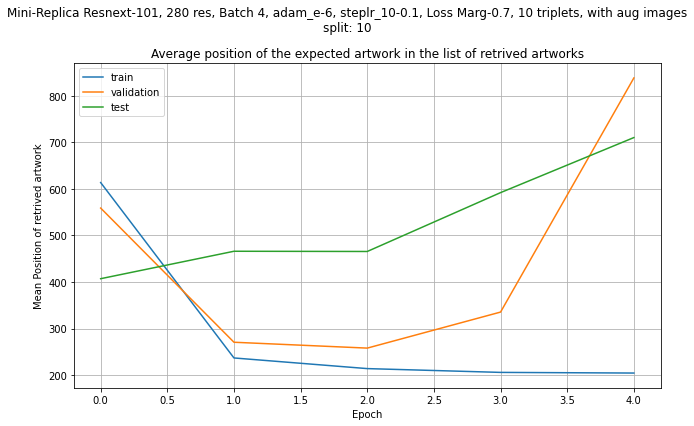

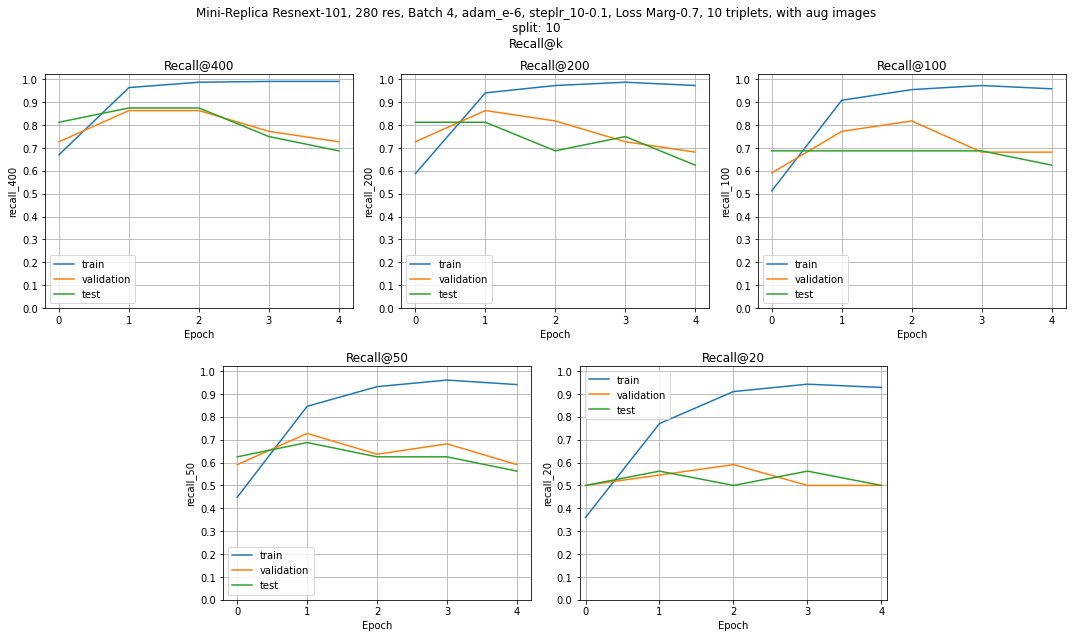

In [25]:
split_id = 10

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [26]:
best_epoch = 2

train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT Aug Mini-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

In [27]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
val_metrics_df = pd.DataFrame(val_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
test_metrics_df = pd.DataFrame(test_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
non_train_metrics_df = pd.DataFrame(non_train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])

In [28]:
train_metrics_df["MAP"] = 100 * train_metrics_df["MAP"]
train_metrics_df["R@400"] = 100 * train_metrics_df["R@400"]
train_metrics_df["R@200"] = 100 * train_metrics_df["R@200"]
train_metrics_df["R@100"] = 100 * train_metrics_df["R@100"]
train_metrics_df["R@50"] = 100 * train_metrics_df["R@50"]
train_metrics_df["R@20"] = 100 * train_metrics_df["R@20"]

val_metrics_df["MAP"] = 100 * val_metrics_df["MAP"]
val_metrics_df["R@400"] = 100 * val_metrics_df["R@400"]
val_metrics_df["R@200"] = 100 * val_metrics_df["R@200"]
val_metrics_df["R@100"] = 100 * val_metrics_df["R@100"]
val_metrics_df["R@50"] = 100 * val_metrics_df["R@50"]
val_metrics_df["R@20"] = 100 * val_metrics_df["R@20"]

test_metrics_df["MAP"] = 100 * test_metrics_df["MAP"]
test_metrics_df["R@400"] = 100 * test_metrics_df["R@400"]
test_metrics_df["R@200"] = 100 * test_metrics_df["R@200"]
test_metrics_df["R@100"] = 100 * test_metrics_df["R@100"]
test_metrics_df["R@50"] = 100 * test_metrics_df["R@50"]
test_metrics_df["R@20"] = 100 * test_metrics_df["R@20"]

non_train_metrics_df["MAP"] = 100 * non_train_metrics_df["MAP"]
non_train_metrics_df["R@400"] = 100 * non_train_metrics_df["R@400"]
non_train_metrics_df["R@200"] = 100 * non_train_metrics_df["R@200"]
non_train_metrics_df["R@100"] = 100 * non_train_metrics_df["R@100"]
non_train_metrics_df["R@50"] = 100 * non_train_metrics_df["R@50"]
non_train_metrics_df["R@20"] = 100 * non_train_metrics_df["R@20"]

In [29]:
train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,0,2,205.578947,14.164875,203.754480,73.843709,99.103943,98.028674,97.132616,94.086022,90.322581
1,FT Aug Mini-Replica,1,1,273.321429,117.170833,254.454167,48.786159,94.166667,90.416667,83.333333,78.125000,69.375000
2,FT Aug Mini-Replica,2,2,202.626471,12.567073,197.848577,77.520822,98.780488,98.373984,97.560976,95.325203,93.089431
3,FT Aug Mini-Replica,3,3,198.496795,1.997835,195.905844,87.933701,100.000000,100.000000,99.567100,99.134199,97.186147
4,FT Aug Mini-Replica,4,3,203.871486,3.148148,199.469136,85.285625,99.176955,98.559671,97.942387,97.325103,96.502058
5,FT Aug Mini-Replica,5,3,197.950581,4.769076,192.756024,86.689054,99.598394,98.594378,98.192771,97.389558,96.184739
6,FT Aug Mini-Replica,6,2,226.638211,63.512500,222.535417,71.164259,97.708333,96.875000,93.125000,90.208333,86.041667
7,FT Aug Mini-Replica,7,1,216.792105,38.259857,213.384409,62.510772,98.387097,94.623656,90.143369,86.021505,79.211470
8,FT Aug Mini-Replica,8,2,199.133721,11.570281,192.375502,80.353402,99.196787,98.795181,98.594378,98.192771,95.783133
9,FT Aug Mini-Replica,9,3,197.098333,8.083333,189.803819,82.737667,99.305556,99.131944,98.437500,96.527778,94.097222


In [30]:
val_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,0,2,352.325000,341.631579,349.868421,53.038546,84.210526,84.210526,73.684211,73.684211,68.421053
1,FT Aug Mini-Replica,1,1,374.133333,348.266667,374.133333,30.002380,90.000000,83.333333,70.000000,63.333333,50.000000
2,FT Aug Mini-Replica,2,2,381.568182,363.136364,381.568182,41.694633,81.818182,68.181818,63.636364,59.090909,50.000000
3,FT Aug Mini-Replica,3,3,237.683333,90.931034,232.396552,25.884898,93.103448,89.655172,82.758621,62.068966,48.275862
4,FT Aug Mini-Replica,4,3,285.709677,189.733333,282.233333,24.522248,90.000000,86.666667,76.666667,70.000000,50.000000
5,FT Aug Mini-Replica,5,3,231.620690,63.241379,231.620690,42.006689,96.551724,93.103448,86.206897,79.310345,55.172414
6,FT Aug Mini-Replica,6,2,397.825000,151.611111,275.361111,29.565083,77.777778,77.777778,72.222222,66.666667,61.111111
7,FT Aug Mini-Replica,7,1,542.210526,684.421053,542.210526,21.482077,78.947368,68.421053,63.157895,47.368421,47.368421
8,FT Aug Mini-Replica,8,2,535.016129,314.033333,369.916667,22.172580,83.333333,80.000000,76.666667,66.666667,53.333333
9,FT Aug Mini-Replica,9,3,263.131579,126.263158,263.131579,46.665748,89.473684,73.684211,68.421053,68.421053,63.157895


In [31]:
test_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,0,2,377.400000,393.894737,376.526316,50.997425,89.473684,89.473684,89.473684,84.210526,68.421053
1,FT Aug Mini-Replica,1,1,373.619048,347.238095,373.619048,40.341158,85.714286,76.190476,71.428571,61.904762,52.380952
2,FT Aug Mini-Replica,2,2,344.357143,313.259259,342.777778,24.893742,92.592593,77.777778,70.370370,59.259259,51.851852
3,FT Aug Mini-Replica,3,3,663.777778,412.160000,410.520000,31.502765,80.000000,80.000000,76.000000,64.000000,52.000000
4,FT Aug Mini-Replica,4,3,339.666667,308.300000,337.100000,34.237879,85.000000,75.000000,70.000000,60.000000,50.000000
5,FT Aug Mini-Replica,5,3,213.950000,49.684211,204.526316,49.187437,94.736842,94.736842,84.210526,78.947368,68.421053
6,FT Aug Mini-Replica,6,2,410.121212,420.242424,410.121212,21.368028,75.757576,63.636364,48.484848,45.454545,39.393939
7,FT Aug Mini-Replica,7,1,528.142857,96.105263,247.105263,42.570548,84.210526,78.947368,68.421053,63.157895,57.894737
8,FT Aug Mini-Replica,8,2,298.611111,197.222222,298.611111,33.771234,94.444444,88.888889,83.333333,66.666667,55.555556
9,FT Aug Mini-Replica,9,3,234.281250,68.562500,234.281250,49.483259,100.000000,87.500000,75.000000,62.500000,56.250000


In [32]:
non_train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,0,2,364.862500,367.763158,363.197368,52.017985,86.842105,86.842105,81.578947,78.947368,68.421053
1,FT Aug Mini-Replica,1,1,373.921569,347.843137,373.921569,34.259524,88.235294,80.392157,70.588235,62.745098,50.980392
2,FT Aug Mini-Replica,2,2,360.730000,335.653061,360.193878,32.436999,87.755102,73.469388,67.346939,59.183673,51.020408
3,FT Aug Mini-Replica,3,3,439.517544,239.648148,314.861111,28.485762,87.037037,85.185185,79.629630,62.962963,50.000000
4,FT Aug Mini-Replica,4,3,307.500000,237.160000,304.180000,28.408500,88.000000,82.000000,74.000000,66.000000,50.000000
5,FT Aug Mini-Replica,5,3,224.408163,57.875000,220.895833,44.849069,95.833333,93.750000,85.416667,79.166667,60.416667
6,FT Aug Mini-Replica,6,2,405.481132,325.431373,362.558824,24.261106,76.470588,68.627451,56.862745,52.941176,47.058824
7,FT Aug Mini-Replica,7,1,534.825000,390.263158,394.657895,32.026313,81.578947,73.684211,65.789474,55.263158,52.631579
8,FT Aug Mini-Replica,8,2,448.173469,270.229167,343.177083,26.522075,87.500000,83.333333,79.166667,66.666667,54.166667
9,FT Aug Mini-Replica,9,3,249.942857,99.885714,249.942857,47.953753,94.285714,80.000000,71.428571,65.714286,60.000000


In [33]:
train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/train_scores_kfold.csv", index=False)
val_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/val_scores_kfold.csv", index=False)
test_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/test_scores_kfold.csv", index=False)
non_train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/non_train_scores_kfold.csv", index=False)

In [3]:
train_metrics_df= pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/train_scores_kfold.csv")
val_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/val_scores_kfold.csv")
test_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/test_scores_kfold.csv")
non_train_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_minireplica_aug/non_train_scores_kfold.csv")

In [4]:
get_averaged_df(train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,212.32 ± 22.28,26.93 ± 35.05,75.65 ± 11.66,98.56 ± 1.58,97.34 ± 2.69,95.41 ± 4.87,93.23 ± 6.32,89.89 ± 8.66


In [5]:
get_averaged_df(val_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,350.83 ± 110.37,257.01 ± 179.22,35.26 ± 11.83,86.51 ± 5.9,80.62 ± 8.1,74.11 ± 7.59,65.48 ± 8.24,55.08 ± 6.94


In [6]:
get_averaged_df(test_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,386.3 ± 129.85,285.21 ± 160.47,37.42 ± 9.97,88.13 ± 7.05,80.08 ± 9.39,73.22 ± 10.84,64.42 ± 10.14,54.74 ± 8.3


In [7]:
get_averaged_df(non_train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT Aug Mini-Replica,368.21 ± 89.35,271.3 ± 107.33,35.88 ± 9.52,87.31 ± 5.23,80.33 ± 7.09,73.47 ± 8.2,64.8 ± 8.28,54.54 ± 6.19
